<a href="https://colab.research.google.com/github/KimJisanER/LAIDD/blob/main/Virtual_Screening_%EC%8B%A4%EC%8A%B5%EC%9A%A9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ligand Based Virtual Screening based on JAK2 inhibitor activity prediction model 

## **Goal of the Project**
- Build Deep Learning Model to predict the activty of JAK2 inhibitors
- Screening molecules with high activity with JAK2. 


>## **Janus kinase**
Janus kinase (JAK) is a family of intracellular, non-receptor tyrosine kinases that transduce cytokine-mediated signals via the JAK-STAT pathway. They were initially named "just another kinase" 1 and 2 (since they were just two of many discoveries in a PCR-based screen of kinases),[1] but were ultimately published as "Janus kinase". The name is taken from the two-faced Roman god of beginnings, endings and duality, Janus, because the JAKs possess two near-identical phosphate-transferring domains. One domain exhibits the kinase activity, while the other negatively regulates the kinase activity of the first.
![picture](https://upload.wikimedia.org/wikipedia/commons/thumb/3/35/Protein_JAK2_PDB_2b7a.png/500px-Protein_JAK2_PDB_2b7a.png)

## 1. 필요한 라이브러리 Import 및 다운로드

In [1]:
!pip install -q condacolab
import condacolab
condacolab.install()

import sys
sys.path

import condacolab
condacolab.check()

!mamba install -c conda-forge rdkit==2021.03.5

✨🍰✨ Everything looks OK!
✨🍰✨ Everything looks OK!

                  __    __    __    __
                 /  \  /  \  /  \  /  \
                /    \/    \/    \/    \
███████████████/  /██/  /██/  /██/  /████████████████████████
              /  / \   / \   / \   / \  \____
             /  /   \_/   \_/   \_/   \    o \__,
            / _/                       \_____/  `
            |/
        ███╗   ███╗ █████╗ ███╗   ███╗██████╗  █████╗
        ████╗ ████║██╔══██╗████╗ ████║██╔══██╗██╔══██╗
        ██╔████╔██║███████║██╔████╔██║██████╔╝███████║
        ██║╚██╔╝██║██╔══██║██║╚██╔╝██║██╔══██╗██╔══██║
        ██║ ╚═╝ ██║██║  ██║██║ ╚═╝ ██║██████╔╝██║  ██║
        ╚═╝     ╚═╝╚═╝  ╚═╝╚═╝     ╚═╝╚═════╝ ╚═╝  ╚═╝

        mamba (0.25.0) supported by @QuantStack

        GitHub:  https://github.com/mamba-org/mamba
        Twitter: https://twitter.com/QuantStack

█████████████████████████████████████████████████████████████


Looking for: ['rdkit==2021.03.5']

[+] 0.0s
[+] 0.1s
conda-for

In [2]:
import rdkit
import rdkit.Chem as Chem

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sklearn

## 2. Data Processing

>## **IC50** 
The **half maximal inhibitory concentration (IC50)** is a measure of the potency of a substance in inhibiting a specific biological or biochemical function.  
IC50 is a quantitative measure that indicates **how much of a particular inhibitory substance (e.g. drug) is needed to inhibit, in vitro, a given biological process or biological component by 50%.** 
The biological component could be an enzyme, cell, cell receptor or microorganism. IC50 values are typically expressed as molar concentration.   
**In general, the IC50 value of a typical drug is around several nM.**  
```
  pIC50 = -log_10(IC50)
```

###2-1. CSV 파일로부터 데이터 추출
- Pandas DataFrame을 이용하여 CSV 파일을 읽음
- Pandas DataFrame 참고 자료 (https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html)
- ChEMBL에서 가져온 JAK2에 대한 Ligand 들의 SMILES code와 pIC50 값 (pChEMBL Value)을 읽어들임

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
JAK2_dataframe = pd.read_csv('/content/drive/MyDrive/JAK2_Chembl.csv')
print(JAK2_dataframe)

     Molecule ChEMBL ID Molecule Name  Molecule Max Phase  Molecular Weight  \
0         CHEMBL3126347           NaN                   0            415.28   
1         CHEMBL3126345           NaN                   0            374.30   
2         CHEMBL3126348           NaN                   0            423.26   
3         CHEMBL3126346           NaN                   0            401.25   
4         CHEMBL3984720           NaN                   0            611.05   
...                 ...           ...                 ...               ...   
6446      CHEMBL4589415           NaN                   0            472.47   
6447      CHEMBL4518786           NaN                   0            443.51   
6448      CHEMBL4750368           NaN                   0            274.35   
6449      CHEMBL1789941   RUXOLITINIB                   4            306.37   
6450      CHEMBL4849617           NaN                   0            509.59   

      #RO5 Violations  AlogP Compound Key  \
0     

#### Input 값은 Smiles, Target value 값은 pChEMBL Value로 저장




In [6]:
smiles = JAK2_dataframe['Smiles']
pic50 = JAK2_dataframe['pChEMBL Value']
print(smiles)
print(pic50)

0       CC(C)(O)c1cc(Cl)c(Nc2nc3ccncc3c3c(=O)[nH]ccc23...
1         O=c1[nH]ccc2c(Nc3c(F)cccc3C(F)(F)F)nc3ccncc3c12
2       O=c1[nH]ccc2c(Nc3c(Cl)cc(-c4ccn[nH]4)cc3Cl)nc3...
3       CC(O)c1cc(Cl)c(Nc2nc3ccncc3c3c(=O)[nH]ccc23)c(...
4       O=C(Nc1cn(CC(=O)N2C[C@@H]3CN(CC4CC4)C[C@@H]3C2...
                              ...                        
6446    O=C(Nc1ccc(CNc2cc(Nc3ccc(N4CCOCC4)cc3)ncn2)cc1...
6447    N#CCC(=O)Nc1ccc(CNc2cc(Nc3ccc(N4CCOCC4)cc3)ncn...
6448                  CNc1nc(C)c(C(=O)/C=C/c2ccc(O)cc2)s1
6449         N#CC[C@H](C1CCCC1)n1cc(-c2ncnc3[nH]ccc23)cn1
6450    CC(C)(C)c1ccc(C(=O)N2CCc3cc(Nc4ncc(F)c(-c5cnn(...
Name: Smiles, Length: 6451, dtype: object
0       7.75
1       7.05
2       9.00
3       9.22
4       9.12
        ... 
6446    6.55
6447    5.84
6448    7.47
6449    7.74
6450    6.22
Name: pChEMBL Value, Length: 6451, dtype: float64


### 2-2. Ligand Featurization

- SMILES 형태로 나타낸 분자를 fingerprint 형태로 featurization

In [7]:
from rdkit.Chem import AllChem
from rdkit import Chem

X = []
for i in smiles:
    mol = Chem.MolFromSmiles(i)
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, 4, nBits=1024)
    fp = np.array(fp)
    X.append(fp)


###2-3. 전체 데이터셋을 Training set, Validation set, Test set 으로 나눔
- Training set: Prediction model을 학습하기 위한 data
- Validation set: Prediction model이 제대로 학습이 진행중인지 확인하는 data
- Test set: Prediction model의 성능을 확인하는 data

In [8]:
import sklearn.model_selection
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, pic50, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = sklearn.model_selection.train_test_split(X_train, y_train, test_size=0.1, random_state=42)

## 3. Deep Learning Model 만들기

In [9]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten

###3-1. 데이터 값들을 Tensor로 변환

In [10]:
X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
y_train = tf.convert_to_tensor(y_train)
X_val = tf.convert_to_tensor(X_val, dtype=tf.float32)
y_val = tf.convert_to_tensor(y_val)
X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)

### 3-2. Deep Learning Model을 Sequential 모델로 정의 
- 아래와 같은 순서로 Layer가  model 정의
1. Dense layer 
2. Dropout layer
3. Dense layer
4. Dropout layer
5. Dense layer

In [83]:
dl_model = Sequential([
                    tf.keras.layers.Dense(64, activation='relu', name="A"),
                    tf.keras.layers.Dropout(0.1),
                    tf.keras.layers.Dense(32, activation='relu', name="B"),
                    tf.keras.layers.Dropout(0.1),
                    tf.keras.layers.Dense(1, name="C"),
])

### 3-3. Model Compile
- Adam Optimizer를 Optimizer로 사용
- Loss Function은 Mean Sequared error function
- Monitoring 할 metric은 mean squared error

- Tensorflow 홈페이지 참조(https://www.tensorflow.org/api_docs/python/tf/keras/Model)

In [84]:
mse = tf.keras.losses.MeanSquaredError()
mmse = tf.keras.metrics.MeanSquaredError()

dl_model.compile(optimizer = 'adam',
                 loss = mse,
                 metrics = mmse)

###3-4.  Early Stopping 설정


>## **Early Stopping**
> -  너무 많은 epoch는 overfitting을 일으키고 너무 적은 epoch는 underfitting을 일으킴
-  일반적으로 validation set에서 성능이 더이상 증가하지 않을 때 학습을 중지
-  patience = 10 -> validation set에서 10 epoch가 지나도 성능이 증가하지 않으면 학습을 중지

- training 데이터를 사용하여 100 epoch까지 Early stopping 을 활용하여 모델 학습
- batch size는 32


In [85]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
history = dl_model.fit(
    x=X_train,
    y=y_train,
    epochs=100,
    batch_size=32,
    callbacks=[callback],               # early stopping
    validation_data=(X_val, y_val)      # X_val, y_val을 validation set으로 사용
)
dl_model.summary()

Epoch 1/100
164/164 [==============================] - 1s 4ms/step - loss: 5.1110 - mean_squared_error: 5.1110 - val_loss: 1.0561 - val_mean_squared_error: 1.0561
Epoch 2/100
164/164 [==============================] - 0s 3ms/step - loss: 1.7076 - mean_squared_error: 1.7076 - val_loss: 0.9746 - val_mean_squared_error: 0.9746
Epoch 3/100
164/164 [==============================] - 0s 3ms/step - loss: 1.4548 - mean_squared_error: 1.4548 - val_loss: 0.9516 - val_mean_squared_error: 0.9516
Epoch 4/100
164/164 [==============================] - 0s 3ms/step - loss: 1.3494 - mean_squared_error: 1.3494 - val_loss: 0.9361 - val_mean_squared_error: 0.9361
Epoch 5/100
164/164 [==============================] - 0s 3ms/step - loss: 1.1861 - mean_squared_error: 1.1861 - val_loss: 0.8822 - val_mean_squared_error: 0.8822
Epoch 6/100
164/164 [==============================] - 0s 3ms/step - loss: 1.1635 - mean_squared_error: 1.1635 - val_loss: 0.9624 - val_mean_squared_error: 0.9624
Epoch 7/100
164/164 [=

## 4. Deep Learning Model Evaluation

#### 만들어진 Deep Learning 모델의 성능 평가
##### X_test 값을 활용하여 dl_model에서 pIC값을 예측

In [86]:
y_pred = dl_model.predict(X_test)

In [87]:
print(y_pred)

[[ 7.155858 ]
 [ 9.003448 ]
 [ 6.0502586]
 [ 8.605072 ]
 [ 5.7395353]
 [ 6.7041063]
 [ 6.357828 ]
 [ 5.260081 ]
 [ 6.09328  ]
 [ 7.185637 ]
 [ 5.7625217]
 [ 7.539097 ]
 [ 7.0865984]
 [ 6.5069637]
 [ 7.804928 ]
 [ 6.9045525]
 [ 5.217723 ]
 [ 6.282531 ]
 [10.432973 ]
 [ 8.559893 ]
 [ 7.737826 ]
 [ 6.6911583]
 [ 7.081011 ]
 [ 7.8346043]
 [ 6.666996 ]
 [ 6.4853764]
 [ 8.166848 ]
 [ 8.749003 ]
 [ 6.944419 ]
 [ 7.0322576]
 [ 8.813408 ]
 [ 5.808464 ]
 [10.01702  ]
 [ 7.828346 ]
 [ 6.976206 ]
 [ 5.870395 ]
 [ 6.224628 ]
 [ 7.680872 ]
 [ 6.4556236]
 [ 7.355727 ]
 [ 7.3939342]
 [ 8.234882 ]
 [ 7.8749113]
 [ 6.613914 ]
 [ 6.6972504]
 [ 6.908571 ]
 [ 5.2409134]
 [ 9.124214 ]
 [ 6.7218046]
 [ 7.9197855]
 [ 9.207811 ]
 [ 8.0182905]
 [ 6.60063  ]
 [ 6.9324627]
 [ 6.421407 ]
 [ 6.240365 ]
 [ 7.4231124]
 [ 6.830451 ]
 [ 8.559246 ]
 [ 6.6400614]
 [ 7.6377473]
 [ 6.3827925]
 [ 9.256572 ]
 [ 6.9722347]
 [ 6.94491  ]
 [ 9.106784 ]
 [ 6.355518 ]
 [ 6.0686975]
 [ 7.130036 ]
 [ 7.330019 ]
 [ 6.600055 ]
 [ 7.2

#### Mean squared error를 통해 정량적으로 성능을 측정

In [88]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_pred,y_test)
print(mse)

0.8740872649276068


#### Epoch에 따른 training loss와 validation loss를 visualization

dict_keys(['loss', 'mean_squared_error', 'val_loss', 'val_mean_squared_error'])


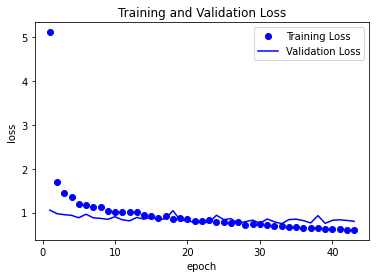

In [89]:
history_dict = history.history
print(history_dict.keys())

loss = history_dict['loss']
val_loss = history_dict['val_loss']

epoch = range(1, len(loss)+1)

plt.plot(epoch, loss, 'bo', label='Training Loss')
plt.plot(epoch, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

### Scatter Plot을 이용하여 예측이 잘 되었는지 확인


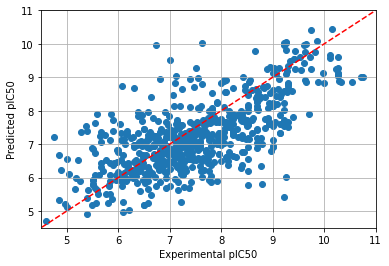

In [90]:
plt.scatter(y_test, y_pred)
plt.xlabel('Experimental pIC50')
plt.ylabel('Predicted pIC50')

plt.grid()
plt.xlim(4.5, 11)
plt.ylim(4.5, 11)
plt.plot(range(4, 12), range(4, 12), "r--", label="y=x")
plt.show()

## 5. Virtual Screening

##### Zinc15 database의 Compound Library로부터 새로운 candidate를 찾기
##### Compound Library를 csv파일로부터 불러들임

In [91]:
compound_lib =pd.read_csv('/content/drive/MyDrive/zinc15_compound_library.csv')
print(compound_lib)

                zinc_id                                             smiles
0      ZINC000023247639  CCN1CCN(Cc2ccc(NC(=O)Nc3ccc(Oc4cc(NC)ncn4)cc3)...
1      ZINC000003964325  CCN(CC)CCNC(=O)c1c(C)[nH]c(/C=C2\C(=O)Nc3ccc(F...
2      ZINC000004793192                    CCN1/C(=C/C(C)=O)Sc2ccc(OC)cc21
3      ZINC000018825344  Cc1[nH]c(/C=C2\C(=O)Nc3ccc(F)cc32)c(C)c1C(=O)N...
4      ZINC000211266712    COc1cccc(C(=O)Nc2nc3cc4c(cc3[nH]2)OC(F)(F)O4)c1
...                 ...                                                ...
78309  ZINC000040935360                     Nc1[nH]nc2ccc(-c3cc[nH]n3)cc12
78310  ZINC000299856072  COc1cccc(NC(=O)c2cnc(N3CCN(c4ccccc4OC)CC3)c([N...
78311  ZINC000103271379  O=C1NC(=O)C(c2c[nH]c3ccccc23)=C1Nc1ccc(OCCNc2c...
78312  ZINC000003874496        O=C(Nc1ccc([N+](=O)[O-])cc1Cl)c1cc(Cl)ccc1O
78313  ZINC000084654286  CSc1ccccc1Nc1nc(N2CCN(C3CCNCC3)CC2)nc2c(NCC3CC...

[78314 rows x 2 columns]


#### Input 값은 SMILES

In [92]:
comp_smiles = compound_lib['smiles']

#### Compound SMILES로부터 분자 읽어들이기

In [93]:
X_comp = []
for i in comp_smiles:
    mol = Chem.MolFromSmiles(i)
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, 4, nBits=1024),
    fp = np.array(fp)
    X_comp.append(fp)

#### 개발한 QSAR regression model (Deep learning model :dl_model)을 Compound Library에 적용

In [94]:
# # 데이터를 tensor로 변환 후
X_comp = tf.convert_to_tensor(X_comp)

In [95]:
# dl_model을 통해 예측값을 구함
comp_predict = dl_model.predict(X_comp)

#### 예측값을 compound library 데이터프레임에 새로운 column으로 입력

In [96]:
compound_lib

,zinc_id,smiles
0,ZINC000023247639,CCN1CCN(Cc2ccc(NC(=O)Nc3ccc(Oc4cc(NC)ncn4)cc3)...
1,ZINC000003964325,CCN(CC)CCNC(=O)c1c(C)[nH]c(/C=C2\C(=O)Nc3ccc(F...
2,ZINC000004793192,CCN1/C(=C/C(C)=O)Sc2ccc(OC)cc21
3,ZINC000018825344,Cc1[nH]c(/C=C2\C(=O)Nc3ccc(F)cc32)c(C)c1C(=O)N...
4,ZINC000211266712,COc1cccc(C(=O)Nc2nc3cc4c(cc3[nH]2)OC(F)(F)O4)c1
...,...,...
78309,ZINC000040935360,Nc1[nH]nc2ccc(-c3cc[nH]n3)cc12
78310,ZINC000299856072,COc1cccc(NC(=O)c2cnc(N3CCN(c4ccccc4OC)CC3)c([N...
78311,ZINC000103271379,O=C1NC(=O)C(c2c[nH]c3ccccc23)=C1Nc1ccc(OCCNc2c...
78312,ZINC000003874496,O=C(Nc1ccc([N+](=O)[O-])cc1Cl)c1cc(Cl)ccc1O


In [97]:
comp_predict

array([[[5.7196054]],

       [[6.1035132]],

       [[4.9060636]],

       ...,

       [[5.3117895]],

       [[5.2313004]],

       [[6.369855 ]]], dtype=float32)

In [98]:
comp_predict=comp_predict.reshape(78314,-1)

In [99]:
compound_lib['predicted_pIC50'] = comp_predict

In [100]:
print(compound_lib)

                zinc_id                                             smiles  \
0      ZINC000023247639  CCN1CCN(Cc2ccc(NC(=O)Nc3ccc(Oc4cc(NC)ncn4)cc3)...   
1      ZINC000003964325  CCN(CC)CCNC(=O)c1c(C)[nH]c(/C=C2\C(=O)Nc3ccc(F...   
2      ZINC000004793192                    CCN1/C(=C/C(C)=O)Sc2ccc(OC)cc21   
3      ZINC000018825344  Cc1[nH]c(/C=C2\C(=O)Nc3ccc(F)cc32)c(C)c1C(=O)N...   
4      ZINC000211266712    COc1cccc(C(=O)Nc2nc3cc4c(cc3[nH]2)OC(F)(F)O4)c1   
...                 ...                                                ...   
78309  ZINC000040935360                     Nc1[nH]nc2ccc(-c3cc[nH]n3)cc12   
78310  ZINC000299856072  COc1cccc(NC(=O)c2cnc(N3CCN(c4ccccc4OC)CC3)c([N...   
78311  ZINC000103271379  O=C1NC(=O)C(c2c[nH]c3ccccc23)=C1Nc1ccc(OCCNc2c...   
78312  ZINC000003874496        O=C(Nc1ccc([N+](=O)[O-])cc1Cl)c1cc(Cl)ccc1O   
78313  ZINC000084654286  CSc1ccccc1Nc1nc(N2CCN(C3CCNCC3)CC2)nc2c(NCC3CC...   

       predicted_pIC50  
0             5.719605  
1            

#### 전체 compound library 데이터를 'predicted_pIC50'값으로 내림차순 정렬
- 참고자료: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sort_values.html

In [101]:
sorted_data = compound_lib.sort_values(by=['predicted_pIC50'], ascending=False)
print(sorted_data)

                zinc_id                                             smiles  \
77064  ZINC000096282528  O=C(O)c1ccc(Nc2nc3c(-c4cnn(C5CCCC5)c4)cccn3n2)cc1   
23388  ZINC000168934370  CS(=O)(=O)N1CCC[C@H](Nc2ncncc2-c2cnc3[nH]ccc3n...   
77848  ZINC000168934370  CS(=O)(=O)N1CCC[C@H](Nc2ncncc2-c2cnc3[nH]ccc3n...   
54911  ZINC000168934370  CS(=O)(=O)N1CCC[C@H](Nc2ncncc2-c2cnc3[nH]ccc3n...   
1894   ZINC000084713925  O=C1[C@H](Nc2cc(F)cc(Cl)c2)CCCN1[C@@H]1CCCN(c2...   
...                 ...                                                ...   
14734  ZINC000103236201                          Cc1c(O)c(O)c(O)c2c1COC2=O   
19205  ZINC000000587938   c1ccc(-n2cnc3cc(-c4ccc(OCCN5CCCCC5)cc4)cnc32)cc1   
41703  ZINC000008437745                                            NC(N)=S   
41655  ZINC000008437745                                            NC(N)=S   
74219  ZINC000001529266                         CCN(CC)C(=S)SSC(=S)N(CC)CC   

       predicted_pIC50  
77064        10.017020  
23388        

#### 가장 높은 activity를 보일 것으로 예측된 100개의 후보물질들을 뽑음
- 참고자료: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.iloc.html

In [102]:
candidates = sorted_data.head(100)
print(candidates)

                zinc_id                                             smiles  \
77064  ZINC000096282528  O=C(O)c1ccc(Nc2nc3c(-c4cnn(C5CCCC5)c4)cccn3n2)cc1   
23388  ZINC000168934370  CS(=O)(=O)N1CCC[C@H](Nc2ncncc2-c2cnc3[nH]ccc3n...   
77848  ZINC000168934370  CS(=O)(=O)N1CCC[C@H](Nc2ncncc2-c2cnc3[nH]ccc3n...   
54911  ZINC000168934370  CS(=O)(=O)N1CCC[C@H](Nc2ncncc2-c2cnc3[nH]ccc3n...   
1894   ZINC000084713925  O=C1[C@H](Nc2cc(F)cc(Cl)c2)CCCN1[C@@H]1CCCN(c2...   
...                 ...                                                ...   
72541  ZINC000043207851       N#CC[C@H](C1CCCC1)n1cc(-c2ncnc3[nH]ccc23)cn1   
54456  ZINC000043207851       N#CC[C@H](C1CCCC1)n1cc(-c2ncnc3[nH]ccc23)cn1   
36940  ZINC000043207851       N#CC[C@H](C1CCCC1)n1cc(-c2ncnc3[nH]ccc23)cn1   
74155  ZINC000043207851       N#CC[C@H](C1CCCC1)n1cc(-c2ncnc3[nH]ccc23)cn1   
62702  ZINC000043207851       N#CC[C@H](C1CCCC1)n1cc(-c2ncnc3[nH]ccc23)cn1   

       predicted_pIC50  
77064        10.017020  
23388        

## 6. Training에 활용된 데이터와 비슷한 Ligand 제거

#### 후보물질들의 SMILES를 구함

In [103]:
cand_smiles = candidates['smiles']
print(cand_smiles)

77064    O=C(O)c1ccc(Nc2nc3c(-c4cnn(C5CCCC5)c4)cccn3n2)cc1
23388    CS(=O)(=O)N1CCC[C@H](Nc2ncncc2-c2cnc3[nH]ccc3n...
77848    CS(=O)(=O)N1CCC[C@H](Nc2ncncc2-c2cnc3[nH]ccc3n...
54911    CS(=O)(=O)N1CCC[C@H](Nc2ncncc2-c2cnc3[nH]ccc3n...
1894     O=C1[C@H](Nc2cc(F)cc(Cl)c2)CCCN1[C@@H]1CCCN(c2...
                               ...                        
72541         N#CC[C@H](C1CCCC1)n1cc(-c2ncnc3[nH]ccc23)cn1
54456         N#CC[C@H](C1CCCC1)n1cc(-c2ncnc3[nH]ccc23)cn1
36940         N#CC[C@H](C1CCCC1)n1cc(-c2ncnc3[nH]ccc23)cn1
74155         N#CC[C@H](C1CCCC1)n1cc(-c2ncnc3[nH]ccc23)cn1
62702         N#CC[C@H](C1CCCC1)n1cc(-c2ncnc3[nH]ccc23)cn1
Name: smiles, Length: 100, dtype: object


#### 후보물질 및 Training 데이터의 SMILES로부터 ECFP Fingerprint 생성 (as a bit-vector)

In [104]:
# 후보물질들의 SMILES로부터 분자 읽어들이기
zincs = []
for i in cand_smiles:
    mol = Chem.MolFromSmiles(i)
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, 4, nBits=1024)                                                       # numpy로 변환해서는 안됨
    zincs.append(fp)


# Training에 활용된 데이터의 SMILES로부터 분자 읽어들이기
chembls = []
for i in smiles:
    mol = Chem.MolFromSmiles(i)
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, 4, nBits=1024)                                                             # numpy로 변환해서는 안됨
    chembls.append(fp)

#### 분자 사이의 유사도 계산

In [105]:
from rdkit import DataStructs
sims = []                                                          # 후보물질의 각 분자 당 유사도의 최고값을 저장
for x in zincs:                                                    # 후보물질들을 하나씩 불러옴 (x)
    max_similarity = -9999
    for y in chembls:                                              # Training 데이터를 하나씩 불러옴 (y)
        similarity = DataStructs.FingerprintSimilarity(x, y)       # 후보물질과 Training 데이터의 Tanimoto 유사도 계산
        if max_similarity < similarity:
            max_similarity = similarity
    sims.append(max_similarity)                                    # 가장 높은 유사도를 저장

####Tanimoto 유사도 최고값을 candidate 데이터프레임에 새로운 column으로 입력

In [106]:
candidates.insert(2, "max_tanimoto_similarity", sims, True)
candidates

,zinc_id,smiles,max_tanimoto_similarity,predicted_pIC50
77064,ZINC000096282528,O=C(O)c1ccc(Nc2nc3c(-c4cnn(C5CCCC5)c4)cccn3n2)cc1,1.000000,10.017020
23388,ZINC000168934370,CS(=O)(=O)N1CCC[C@H](Nc2ncncc2-c2cnc3[nH]ccc3n...,1.000000,9.971439
77848,ZINC000168934370,CS(=O)(=O)N1CCC[C@H](Nc2ncncc2-c2cnc3[nH]ccc3n...,1.000000,9.971439
54911,ZINC000168934370,CS(=O)(=O)N1CCC[C@H](Nc2ncncc2-c2cnc3[nH]ccc3n...,1.000000,9.971439
1894,ZINC000084713925,O=C1[C@H](Nc2cc(F)cc(Cl)c2)CCCN1[C@@H]1CCCN(c2...,0.362205,9.814370
...,...,...,...,...
72541,ZINC000043207851,N#CC[C@H](C1CCCC1)n1cc(-c2ncnc3[nH]ccc23)cn1,1.000000,8.908653
54456,ZINC000043207851,N#CC[C@H](C1CCCC1)n1cc(-c2ncnc3[nH]ccc23)cn1,1.000000,8.908653
36940,ZINC000043207851,N#CC[C@H](C1CCCC1)n1cc(-c2ncnc3[nH]ccc23)cn1,1.000000,8.908653
74155,ZINC000043207851,N#CC[C@H](C1CCCC1)n1cc(-c2ncnc3[nH]ccc23)cn1,1.000000,8.908653


#### Training 데이터 중 Tanimoto 유사도가 0.9 이상인 분자가 있는 후보물질을 제외한 나머지 가운데 10개의 compound를 final candidate로 선정

In [107]:
final_candidates = candidates[candidates.max_tanimoto_similarity<0.9]
final_candidates = final_candidates.head(10)
final_candidates

,zinc_id,smiles,max_tanimoto_similarity,predicted_pIC50
1894,ZINC000084713925,O=C1[C@H](Nc2cc(F)cc(Cl)c2)CCCN1[C@@H]1CCCN(c2...,0.362205,9.814370
1893,ZINC000084713920,O=C1[C@@H](Nc2cc(F)cc(Cl)c2)CCCN1[C@@H]1CCCN(c...,0.362205,9.814370
65965,ZINC000045495356,COc1cc2nccc(Nc3ccc(N4C(=O)c5ccc(Cl)cc5C4=O)c(C...,0.242038,9.655154
57417,ZINC000084619930,Cc1cn2c(-c3cnn(CC(=O)Nc4ccncc4O)c3)cnc2c(Nc2cc...,0.203704,9.389006
42918,ZINC000084619930,Cc1cn2c(-c3cnn(CC(=O)Nc4ccncc4O)c3)cnc2c(Nc2cc...,0.203704,9.389006
57418,ZINC000084619932,Cc1cn2c(-c3cnn(CC(=O)Nc4ccncc4O)c3)cnc2c(Nc2cc...,0.203704,9.389006
42919,ZINC000084619932,Cc1cn2c(-c3cnn(CC(=O)Nc4ccncc4O)c3)cnc2c(Nc2cc...,0.203704,9.389006
20433,ZINC000084632856,Cc1cn2c(-c3cnn(CC(=O)Nc4ccncc4F)c3)cnc2c(Nc2cc...,0.200000,9.137799
8074,ZINC000084632856,Cc1cn2c(-c3cnn(CC(=O)Nc4ccncc4F)c3)cnc2c(Nc2cc...,0.200000,9.137799
4546,ZINC000084632858,Cc1cn2c(-c3cnn(CC(=O)Nc4ccncc4F)c3)cnc2c(Nc2cc...,0.200000,9.137799
